# Pytorch Ciphar10 Image Classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torchvision import transforms

## Data Loading and Transformation

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_data = CIFAR10(root='./train', download=True, train=True, transform=train_transforms)
test_data = CIFAR10(root='./test', download=True, train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(train_data)
print(test_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./train
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
batch_size = 8
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size, shuffle=False, num_workers=2)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

## Data Visualization

In [ ]:
def show(img, labels):
  str_labels = [classes[i] for i in labels]
  img = np.transpose(img.numpy(), (1, 2, 0))
  img = (img * std) + mean
  plt.imshow(img)
  plt.title(' '.join(str_labels))
  plt.show()

In [ ]:
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

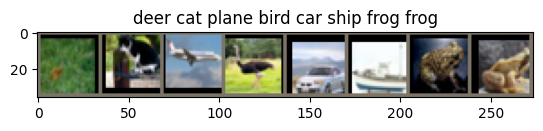

In [ ]:
show(make_grid(images), labels)

## Simple CNN Architecture

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        # Feature Extractor Backbone
        nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Classifier Head
        nn.Flatten(),
        nn.Linear(32*8*8, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
  def forward(self, x):
    return self.model(x)


In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Training Model (With GPU)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda:0


In [ ]:
epochs = 30

for e in range(epochs):
  epoch_loss = 0.0
  for i, data in enumerate(train_loader):
    images, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()
    preds = model(images)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    if i % 2000 == 1999: # 2000 feedforward steps
      print(f'[Epoch {e+1} Step {i+1}]: Loss = {round(epoch_loss/2000, 2)}')
      epoch_loss = 0.0

print('Training Finished!')

[Epoch 1 Step 2000]: Loss = 1.81
[Epoch 1 Step 4000]: Loss = 1.55
[Epoch 1 Step 6000]: Loss = 1.43
[Epoch 2 Step 2000]: Loss = 1.34
[Epoch 2 Step 4000]: Loss = 1.3
[Epoch 2 Step 6000]: Loss = 1.27
[Epoch 3 Step 2000]: Loss = 1.23
[Epoch 3 Step 4000]: Loss = 1.19
[Epoch 3 Step 6000]: Loss = 1.18
[Epoch 4 Step 2000]: Loss = 1.16
[Epoch 4 Step 4000]: Loss = 1.13
[Epoch 4 Step 6000]: Loss = 1.13
[Epoch 5 Step 2000]: Loss = 1.1
[Epoch 5 Step 4000]: Loss = 1.09
[Epoch 5 Step 6000]: Loss = 1.09
[Epoch 6 Step 2000]: Loss = 1.07
[Epoch 6 Step 4000]: Loss = 1.06
[Epoch 6 Step 6000]: Loss = 1.05
[Epoch 7 Step 2000]: Loss = 1.04
[Epoch 7 Step 4000]: Loss = 1.02
[Epoch 7 Step 6000]: Loss = 1.03
[Epoch 8 Step 2000]: Loss = 1.01
[Epoch 8 Step 4000]: Loss = 1.01
[Epoch 8 Step 6000]: Loss = 0.98
[Epoch 9 Step 2000]: Loss = 1.0
[Epoch 9 Step 4000]: Loss = 0.98
[Epoch 9 Step 6000]: Loss = 0.99
[Epoch 10 Step 2000]: Loss = 0.96
[Epoch 10 Step 4000]: Loss = 0.98
[Epoch 10 Step 6000]: Loss = 0.97
[Epoch 11 

In [ ]:
torch.save(model.state_dict(), 'model.pth')

## Model Evaluation

In [ ]:
model = CNN()
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [ ]:
data_iterator = iter(test_loader)
images, labels = next(data_iterator)

In [ ]:
outputs = model(images)
_, predictions = torch.max(outputs, 1)

In [ ]:
def show(img, labels, preds):
  str_labels = [classes[i] for i in labels]
  str_preds = [classes[j] for j in preds]
  img = np.transpose(img.numpy(), (1, 2, 0))
  img = (img * std) + mean
  plt.imshow(img)
  plt.show()
  print('Ground Truth: ', ' '.join(str_labels))
  print('Predictions: ', ' '.join(str_preds))

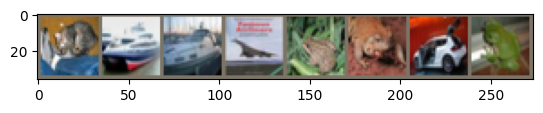

Ground Truth:  cat ship ship plane frog frog car frog
Predictions:  cat car ship plane frog frog car frog


In [ ]:
show(make_grid(images), labels, predictions)

In [ ]:
correct_pred = {name: 0 for name in classes}
total_pred = {name: 0 for name in classes}

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    for label, pred in zip(labels, predictions):
      if label == pred:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for class_name, correct_count in correct_pred.items():
  class_acc = (correct_count/total_pred[class_name]) * 100
  print(f'[Accuracy for class: {class_name}]: {round(class_acc, 2)}')

total_correct = 0
for count in correct_pred.values():
  total_correct += count
test_acc = (total_correct/10000) * 100
print(f'Testing Accuracy: {round(test_acc, 2)} %')

[Accuracy for class: plane]: 80.7
[Accuracy for class: car]: 92.1
[Accuracy for class: bird]: 46.7
[Accuracy for class: cat]: 54.1
[Accuracy for class: deer]: 73.7
[Accuracy for class: dog]: 67.3
[Accuracy for class: frog]: 83.5
[Accuracy for class: horse]: 75.0
[Accuracy for class: ship]: 78.5
[Accuracy for class: truck]: 71.8
Testing Accuracy: 72.34 %
